In [2]:
import pandas as pd
from pandas.core import datetools
import numpy as np
from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA

import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from ipykernel import kernelapp as app


Data from: http://polling.reuters.com/#!response/TM1212Y17/type/smallest/filters/PD1:1/dates/20170524-20180523/collapsed/true

In [3]:
poll_data = pd.read_csv('May2017-May2018_MidtermPoll.tsv', delimiter='\t')
poll_data['time'] = pd.to_datetime(poll_data['time'])
poll_data.set_index('time', inplace=True)
poll_data.drop('Unnamed: 6', axis = 1, inplace=True)
poll_data.drop(pd.to_datetime('2018-01-01'), inplace=True)

col_dtype = {i:'float64' for i in poll_data.columns if i != 'time'}
poll_data = poll_data.astype(col_dtype)


# verify time is in datetime
print(poll_data.info())
print('\nColumn Names: {}'.format(', '.join(poll_data.columns)))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 363 entries, 2017-05-23 to 2018-05-21
Data columns (total 5 columns):
Democratic candidate                      363 non-null float64
Republican candidate                      363 non-null float64
Candidate from another political party    363 non-null float64
Will not/do not plan to vote              363 non-null float64
Don’t know / Refused                      363 non-null float64
dtypes: float64(5)
memory usage: 17.0 KB
None

Column Names: Democratic candidate, Republican candidate, Candidate from another political party, Will not/do not plan to vote, Don’t know / Refused


In [4]:
poll_data.head()

,Democratic candidate,Republican candidate,Candidate from another political party,Will not/do not plan to vote,Don’t know / Refused
time,,,,,
2017-05-23,43.0,36.1,2.8,1.4,17.0
2017-05-24,43.2,36.0,4.0,2.0,14.8
2017-05-25,42.4,35.6,3.5,3.0,15.4
2017-05-26,41.0,36.3,4.0,3.6,15.2
2017-05-27,41.6,35.5,3.9,3.5,15.5


In [8]:
poll_data_diff = poll_data.pct_change().dropna()
poll_data_diff.head()

,Democratic candidate,Republican candidate,Candidate from another political party,Will not/do not plan to vote,Don’t know / Refused
time,,,,,
2017-05-24,0.004651,-0.002770,0.428571,0.428571,-0.129412
2017-05-25,-0.018519,-0.011111,-0.125000,0.500000,0.040541
2017-05-26,-0.033019,0.019663,0.142857,0.200000,-0.012987
2017-05-27,0.014634,-0.022039,-0.025000,-0.027778,0.019737
2017-05-28,-0.040865,0.019718,0.179487,0.171429,-0.019355


In [5]:
poll_data_err_up = poll_data * 1.03
poll_data_err_down = poll_data * 0.97

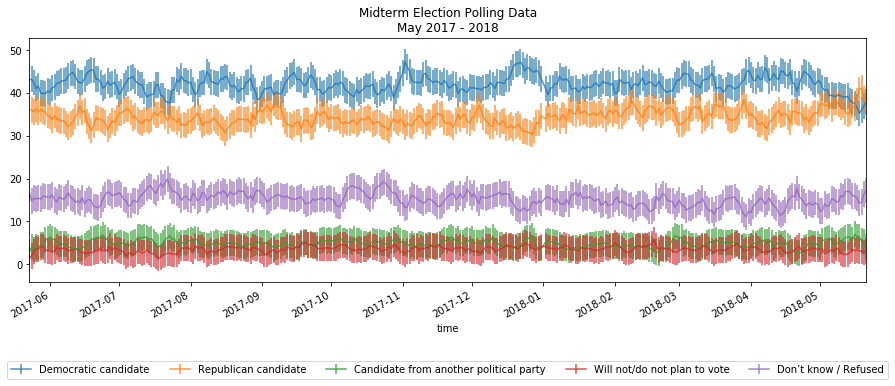

In [6]:
poll_data.plot(
               title='Midterm Election Polling Data\nMay 2017 - 2018',
               alpha = 0.8,
               figsize=(15,5),
               yerr=3
)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          ncol=5, fancybox=True, shadow=False)
plt.show()

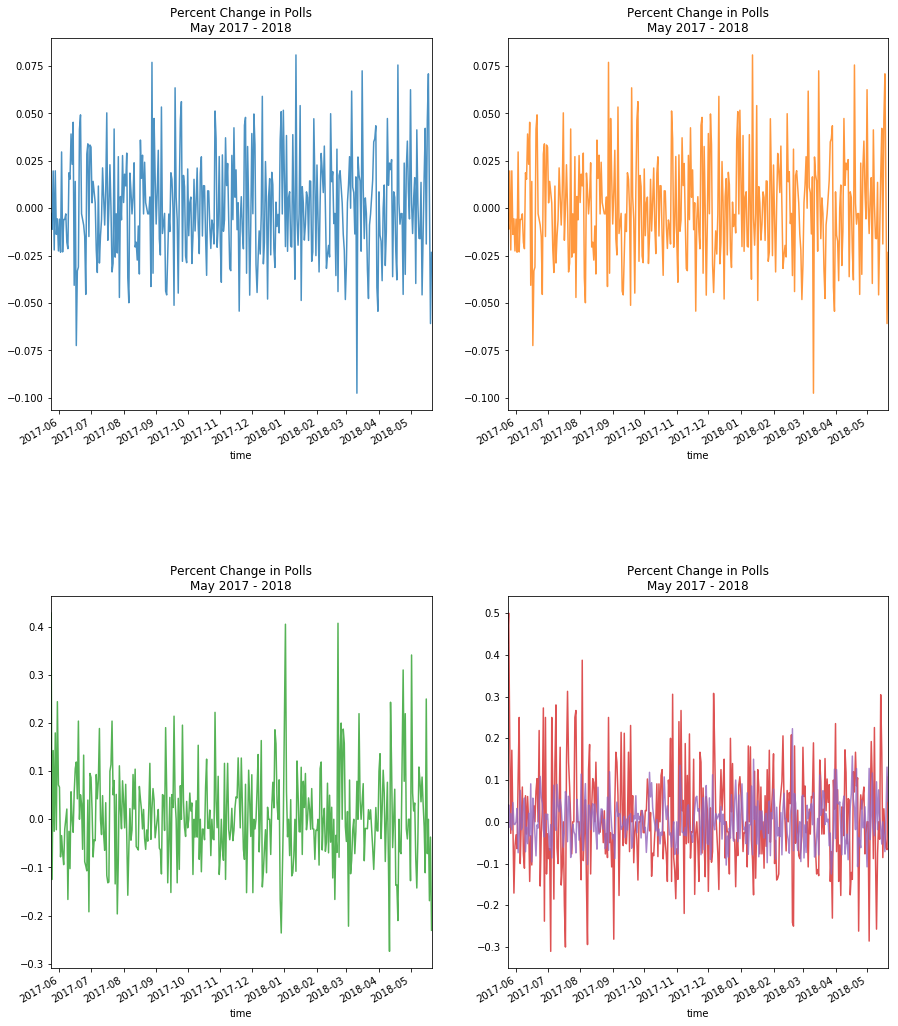

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,19))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.5)

poll_data_diff['Republican candidate'].plot(ax=axes[0][0],
            title='Percent Change in Polls\nMay 2017 - 2018',
            c='C0',
            alpha = 0.8
            )

poll_data_diff['Republican candidate'].plot(ax=axes[0][1],
            title='Percent Change in Polls\nMay 2017 - 2018',
            c='C1',
            alpha = 0.8
            )

poll_data_diff['Candidate from another political party'].plot(ax=axes[1][0],
                title='Percent Change in Polls\nMay 2017 - 2018',
                c='C2',
                alpha = 0.8,
                )

poll_data_diff['Will not/do not plan to vote'].plot(ax=axes[1][1],
            title='Percent Change in Polls\nMay 2017 - 2018',
            c='C3',
            alpha = 0.8,
            )
poll_data_diff['Don’t know / Refused'].plot(ax=axes[1][1],
            title='Percent Change in Polls\nMay 2017 - 2018',
            c='C4',
            alpha = 0.8,
            )

# Move axis from (0,0) to bottom
#axes[0][0].legend(loc='upper center', bbox_to_anchor=(1.05, -2.25),
#          ncol=5, fancybox=True, shadow=False)
# Remove axis for multi-line plots
#axes[0][1].legend_.remove()

In [14]:
resample_end = poll_data.resample('M', convention='end').asfreq().dropna()
resample_start = poll_data.resample('M', convention='start').asfreq().dropna()
resample_end.tail()

,Democratic candidate,Republican candidate,Candidate from another political party,Will not/do not plan to vote,Don’t know / Refused
time,,,,,
2017-12-31,43.3,34.6,3.7,4.1,14.3
2018-01-31,42.2,35.1,4.3,4.3,14.0
2018-02-28,43.0,33.6,6.5,2.8,14.1
2018-03-31,45.3,34.8,4.0,3.4,12.5
2018-04-30,42.8,35.2,4.7,3.5,13.9


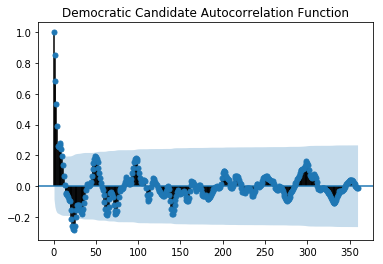

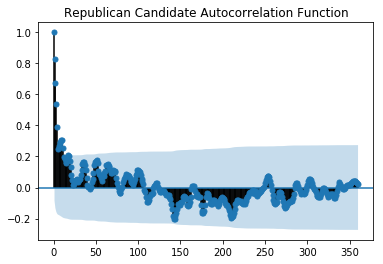

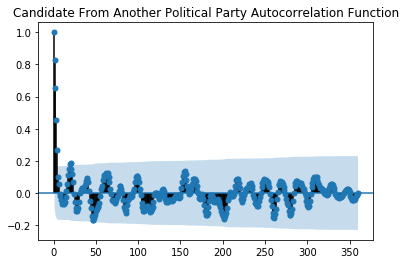

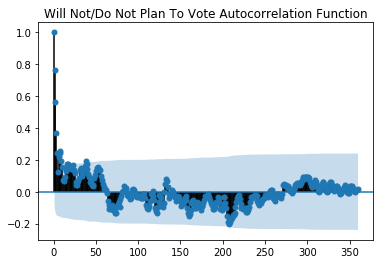

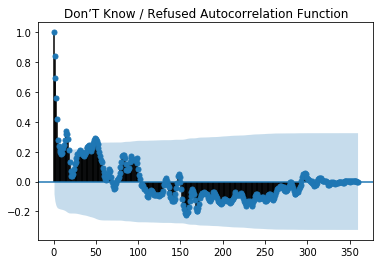

In [70]:
def acf_plot(x, title, lags = None, alpha = None):
    if lags == None:
        lags = x.size - 3
    if alpha == None:
        alpha=1.96/sqrt(x.size)
    poll_data_acf = plot_acf(x.tolist(),
                            lags = lags,
                            alpha = alpha,
                            title = title.title() + ' Autocorrelation Function')

for i in poll_data.columns:
    acf_plot(poll_data[i],i)

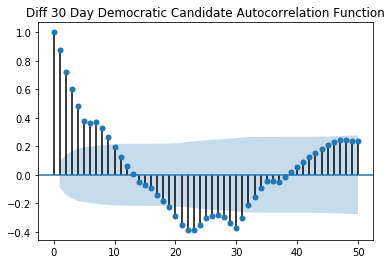

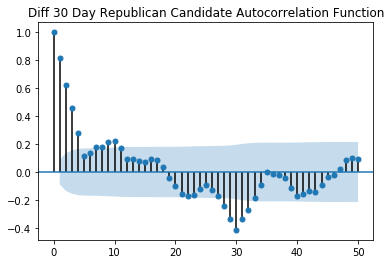

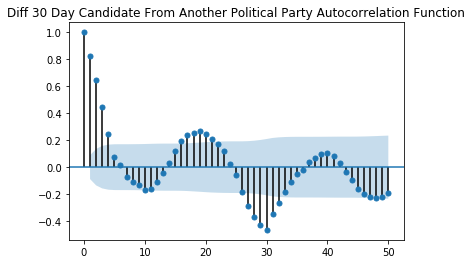

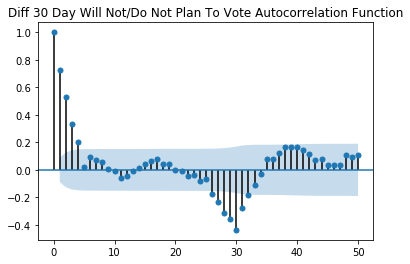

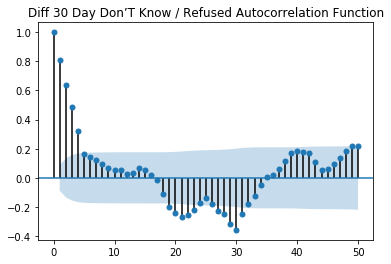

In [178]:
for i in poll_data.columns:
    acf_plot(poll_data[i].diff(30).dropna(),
             'Diff 30 day ' + i,
            lags = 50)

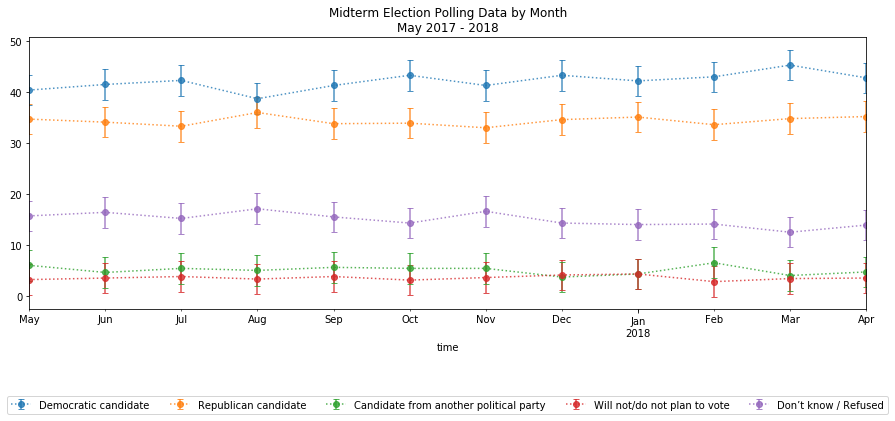

In [63]:
resample_end.plot(
                fmt = ':',
                marker = 'o',
                title = 'Midterm Election Polling Data by Month\nMay 2017 - 2018',
                alpha = 0.8,
                figsize = (15,5),
                yerr = 3,
                capsize = 3
)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          ncol=5, fancybox=True, shadow=False)
plt.show()

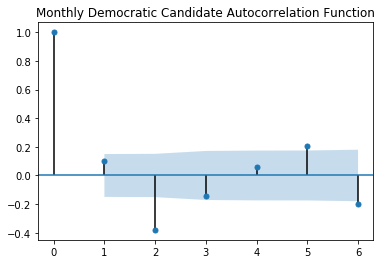

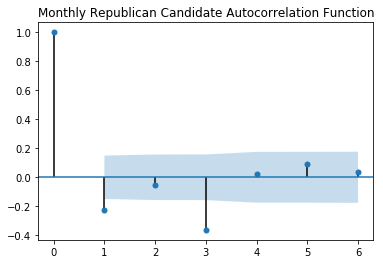

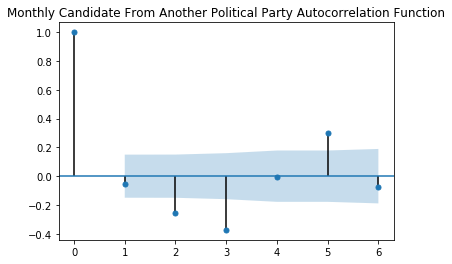

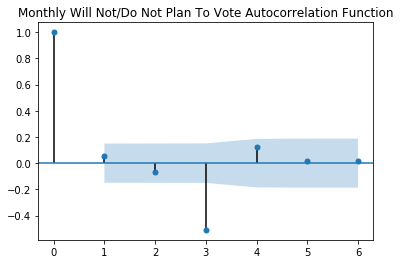

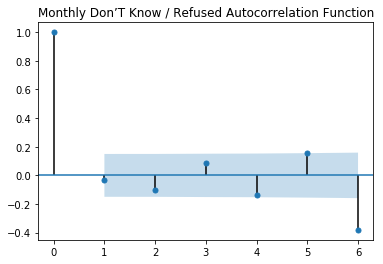

In [86]:
for i in resample_end.columns:
    acf_plot(resample_end[i].diff(3).dropna(),
             'Monthly ' + i,
            )

In [102]:
def arma_plot(x, order = (1,0), end = None, diff = None):
    poll_data_arma = ARMA(x.diff(diff).dropna(),
                            order=order).\
                        fit().\
                        plot_predict(
                            end=end)

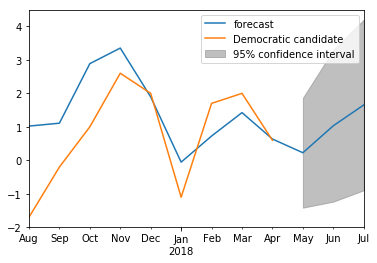

In [101]:
arma_dem = ARIMA(resample_end['Democratic candidate'].diff(3).dropna(), order=(3,0,1)).fit().plot_predict(end='08/2018')

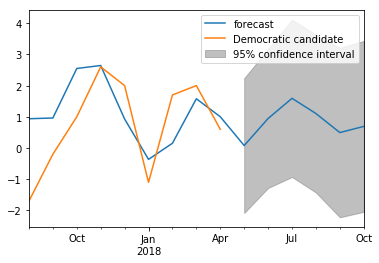

In [104]:
arma_plot(resample_end['Democratic candidate'],
          order = (3,0),
          diff = 3,
          end = '11/2018')

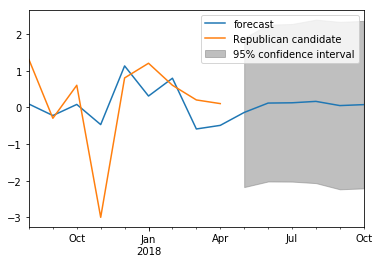

In [105]:
arma_plot(resample_end['Republican candidate'],
          order = (3,0),
          diff = 3,
          end = '11/2018')